<a href="https://colab.research.google.com/github/bethuunltd/Weather-Prediction/blob/main/CNNParameterForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset,DataLoader


In [ ]:
df = pd.read_csv('data.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace= True)
parameter = df[['ws']]
lookback = 10
horizon = 5
n = len(parameter)

scaler = MinMaxScaler()

train_len = 0.7*len(parameter)
val_len = 0.2*len(parameter)

train = parameter[:int(train_len)]
val = parameter[int(train_len):int(train_len+val_len)]
test = parameter[int(train_len+val_len):]


#The scaler has no cross-contamination between features.
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)




In [ ]:
def create_sequences(data,lookback,horizon):
  X,y = [],[]
  for i in range(len(data)-lookback-horizon):
    X.append(data[i:i+lookback])
    y.append(data[i+lookback:i+lookback+horizon])#Starts from the last datapoint of X, and goes "horizon" days more.
  return np.array(X),np.array(y)


X_train,y_train = create_sequences(train_scaled,lookback,horizon)
X_val,y_val = create_sequences(val_scaled,lookback,horizon)
X_test,y_test = create_sequences(test_scaled,lookback,horizon)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_val, y_val)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, drop_last=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, drop_last=True)




In [ ]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size=1, cnn_filters=56, kernel_size=3,
                 hidden_size=64, num_layers=2, horizon=5, dropout=0.3):
        super(CNN_LSTM, self).__init__()
        self.horizon = horizon
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cnn = nn.Conv1d(in_channels=input_size,
                             out_channels=cnn_filters,
                             kernel_size=kernel_size,
                             padding=kernel_size // 2)#Kernel size padding looks back and forth from
        self.relu = nn.ReLU()
        self.cnn_dropout = nn.Dropout(p=dropout)

        self.lstm = nn.LSTM(input_size=cnn_filters,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)

        self.fc_dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, horizon * input_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time)
        x = self.relu(self.cnn(x))
        x = self.cnn_dropout(x)
        x = x.permute(0, 2, 1)  # (batch, time, features)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc_dropout(out[:, -1, :])
        out = self.fc(out)
        out = out.view(-1, self.horizon, self.input_size)
        return out

In [ ]:
class BiLSTM_RNN(nn.Module):
    def __init__(self, input_size=1, lstm_hidden=64, lstm_layers=2, rnn_hidden=32, horizon=5, dropout=0.3):
        super(BiLSTM_RNN, self).__init__()
        self.horizon = horizon
        self.input_size = input_size
        self.lstm_hidden = lstm_hidden
        self.rnn_hidden = rnn_hidden
        self.lstm_layers = lstm_layers

        self.bilstm = nn.LSTM(input_size=input_size,
                              hidden_size=lstm_hidden,
                              num_layers=lstm_layers,
                              batch_first=True,
                              dropout=dropout,
                              bidirectional=True)

        self.rnn = nn.RNN(input_size=2 * lstm_hidden,  # bidirectional doubles hidden size
                          hidden_size=rnn_hidden,
                          num_layers=1,
                          batch_first=True,
                          nonlinearity='tanh')

        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(rnn_hidden, horizon * input_size)

    def forward(self, x):
        h0_bilstm = torch.zeros(self.lstm_layers * 2, x.size(0), self.lstm_hidden, device=x.device)
        c0_bilstm = torch.zeros(self.lstm_layers * 2, x.size(0), self.lstm_hidden, device=x.device)

        out, _ = self.bilstm(x, (h0_bilstm, c0_bilstm))  # (batch, seq_len, 2*lstm_hidden)

        h0_rnn = torch.zeros(1, x.size(0), self.rnn_hidden, device=x.device)
        out, _ = self.rnn(out, h0_rnn)  # (batch, seq_len, rnn_hidden)

        out = self.dropout(out[:, -1, :])  # use last timestep
        out = self.fc(out)
        return out.view(-1, self.horizon, self.input_size)


In [ ]:
class EarlyStoppingSmoothedAverage:
  def __init__(self,window = 5, patience=7,min_delta = 0.000001):
    self.counter = 0
    self.min_loss = np.inf
    self.early_stop = False
    self.patience = patience
    self.window=window
    self.min_delta = min_delta
    self.val_losses = []

  def moving_average(self,values):
    if len(values) < self.window:
      return np.mean(values)
    return np.mean(values[-self.window:])


  def __call__(self,val_loss):
    self.val_losses.append(val_loss)
    if self.moving_average(self.val_losses) < self.min_loss - self.min_delta:
      self.min_loss = self.moving_average(self.val_losses)
      self.counter = 0
    elif self.moving_average(self.val_losses) > self.min_loss + self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True





In [ ]:
#model = CNN_LSTM()
model = BiLSTM_RNN(input_size=1, lstm_hidden=64, lstm_layers=2, rnn_hidden=32, horizon=horizon)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
early_stopper = EarlyStoppingSmoothedAverage()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
best_model = None
train_losses = []
val_losses = []
best_val_loss = float('inf')


In [ ]:
for epoch in range(epochs):
  model.train()
  train_loss= 0
  for X_batch,y_batch in train_loader:
    optimizer.zero_grad()
    y_pred = model(X_batch)
    loss = criterion(y_pred,y_batch)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  train_loss = train_loss/len(train_loader)

  model.eval()
  with torch.no_grad():
    val_loss = 0
    for X_batch,y_batch in val_loader:
      y_pred = model(X_batch)
      loss = criterion(y_pred,y_batch)
      val_loss += loss.item()
    val_loss /= len(val_loader)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pt')

  early_stopper(val_loss)
  if (epoch+1)%2 == 0:
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
  if early_stopper.early_stop:
    print(f"Early stopping at epoch: {epoch}")
    break





Epoch 2, Train Loss: 0.0064, Val Loss: 0.0063
Epoch 4, Train Loss: 0.0058, Val Loss: 0.0059
Epoch 6, Train Loss: 0.0057, Val Loss: 0.0066
Epoch 8, Train Loss: 0.0056, Val Loss: 0.0059
Epoch 10, Train Loss: 0.0056, Val Loss: 0.0060
Epoch 12, Train Loss: 0.0056, Val Loss: 0.0059
Epoch 14, Train Loss: 0.0055, Val Loss: 0.0058
Epoch 16, Train Loss: 0.0054, Val Loss: 0.0058
Epoch 18, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 20, Train Loss: 0.0054, Val Loss: 0.0058
Epoch 22, Train Loss: 0.0054, Val Loss: 0.0057
Epoch 24, Train Loss: 0.0054, Val Loss: 0.0057
Epoch 26, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 28, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 30, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 32, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 34, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 36, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 38, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 40, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 42, Train Loss: 0.0053, Val Loss: 0.0057
Epoch 44, Train L

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

BiLSTM_RNN(
  (bilstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (rnn): RNN(128, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

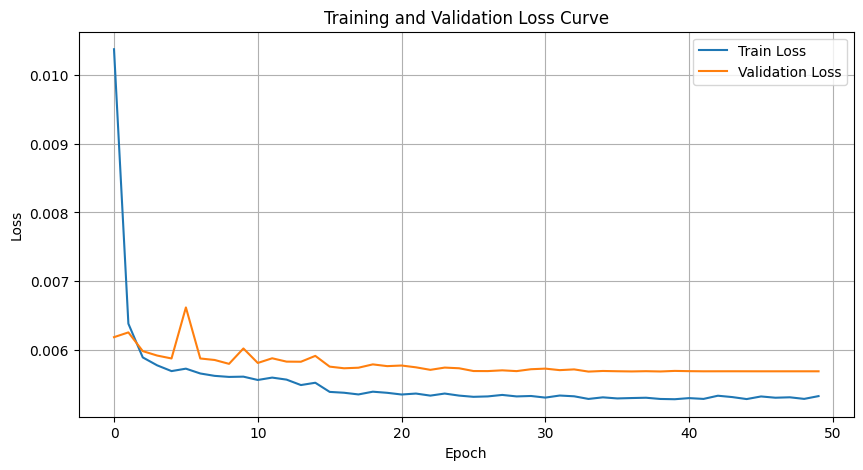

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(model, test_loader, scaler):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            all_preds.append(preds.numpy())
            all_targets.append(y_batch.numpy())

    all_preds = np.concatenate(all_preds, axis=0).reshape(-1, 1)
    all_targets = np.concatenate(all_targets, axis=0).reshape(-1, 1)

    preds_unscaled = scaler.inverse_transform(all_preds).flatten()
    targets_unscaled = scaler.inverse_transform(all_targets).flatten()

    r2 = r2_score(targets_unscaled, preds_unscaled)
    rmse = np.sqrt(mean_squared_error(targets_unscaled, preds_unscaled))
    mae = mean_absolute_error(targets_unscaled, preds_unscaled)

    print(f"R² Score:  {r2:.4f}")
    print(f"RMSE:      {rmse:.4f}")
    print(f"MAE:       {mae:.4f}")

    return r2, rmse, mae


In [ ]:
# Load best model
#model.load_state_dict(torch.load('best_model.pt'))
#model = CNN_LSTM()
#model.load_state_dict(torch.load('best_model.pt'))
model.eval()
r2, rmse, mae = evaluate_model(model, test_loader, scaler)


R² Score:  -0.0918
RMSE:      8.4646
MAE:       6.7618


In [ ]:

def recursive_forecast(model, initial_seq, steps_ahead, lookback, scaler, horizon=5):
    model.eval()
    predictions = []
    curr_input = initial_seq.copy()

    with torch.no_grad():
        while len(predictions) * horizon < steps_ahead:
            input_tensor = torch.tensor(curr_input).unsqueeze(0).float()  # shape: (1, lookback, 1)
            forecast = model(input_tensor).squeeze(0).numpy()  # shape: (horizon, 1)
            predictions.append(forecast)
            curr_input = np.vstack([curr_input, forecast])  # append new forecast
            curr_input = curr_input[-lookback:]  # keep last 'lookback' entries

    predictions = np.vstack(predictions)[:steps_ahead]
    predictions_actual = scaler.inverse_transform(predictions)
    return predictions_actual

<ipython-input-28-317770718>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=steps_ahead, freq='H')


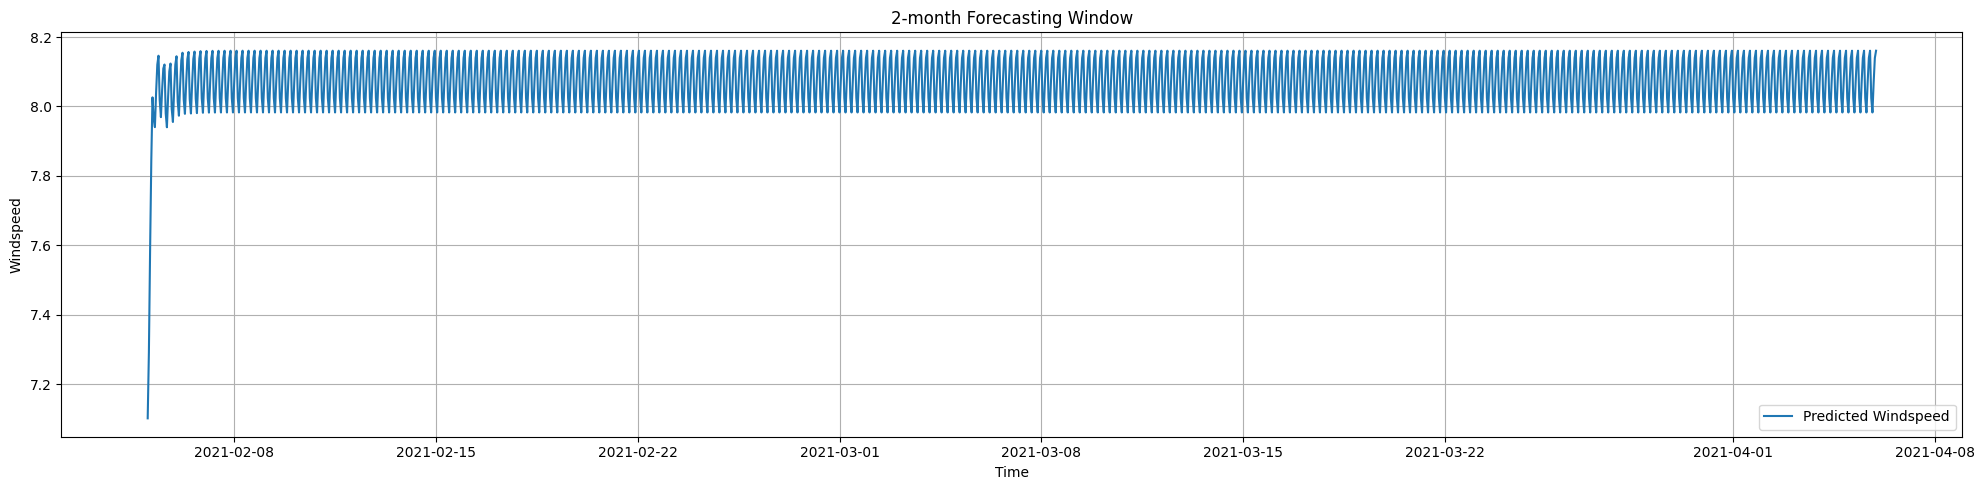

In [ ]:
initial_seq = test_scaled[-lookback:]
steps_ahead = 1440
predicted = recursive_forecast(model, initial_seq, steps_ahead, lookback, scaler, horizon=horizon)

dates = pd.date_range(start=df.index[-1] + pd.Timedelta(hours=1), periods=steps_ahead, freq='H')
plt.figure(figsize=(20, 5))
plt.plot(dates, predicted, label='Predicted Windspeed')
plt.xlabel('Time')
plt.ylabel('Windspeed')
plt.title('2-month Forecasting Window')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
